In [97]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Try using 'ISO-8859-1' or 'latin1' encoding
Dataset = pd.read_csv('C:/Users/kaspe/Documents/GitHub/KCL_Eksamensprojekt/AI_Model_Training/data/20244281821457313338UHELDK129906013912.csv', names=column_names, sep=';', encoding='ISO-8859-1')

df = Dataset
df.head()

,Gender,Age,Type of Injury,Area,Type of Vehicle,2020,2021,2022
0,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Almindelig personbil,9,7,4
1,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Taxi,0,0,0
2,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Køretøj 0-3.500 kg under udrykning,0,0,0
3,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Varebil 0-3.500 kg.,0,1,0
4,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Lastbil over 3.500 kg.,0,0,0


In [98]:
# Manually specifying column names
column_names = ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle', '2020', '2021', '2022']

# Proceed with the data preparation

# Merge 'Knallert' and 'Knallert 45' into 'Knallert'
df['Type of Vehicle'] = df['Type of Vehicle'].replace(['Knallert 45'], 'Knallert')

# Sum the incidents from 2020, 2021, 2022 into a single 'Total Incidents' column
df['Total Incidents'] = df[['2020', '2021', '2022']].sum(axis=1)

# Drop the now unnecessary year columns
df.drop(['2020', '2021', '2022'], axis=1, inplace=True)

# Create a copy of the dataframe for encoding
df_encoded = df.copy()

# Initialize a label encoder for each categorical column
label_encoders = {}
for column in ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle']:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le

# Now, `df_encoded` contains integers instead of string categories


In [99]:
df.head()

,Gender,Age,Type of Injury,Area,Type of Vehicle,Total Incidents
0,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Almindelig personbil,20
1,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Taxi,0
2,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Køretøj 0-3.500 kg under udrykning,0
3,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Varebil 0-3.500 kg.,1
4,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Lastbil over 3.500 kg.,0


In [100]:
df_encoded

,Gender,Age,Type of Injury,Area,Type of Vehicle,Total Incidents
0,1,0,3,0,0,20
1,1,0,3,0,9,0
2,1,0,3,0,6,0
3,1,0,3,0,10,1
4,1,0,3,0,7,0
...,...,...,...,...,...,...
4315,2,5,2,2,5,0
4316,2,5,2,2,5,0
4317,2,5,2,2,3,0
4318,2,5,2,2,4,0


In [101]:
# Group by 'Type of Injury' and create a separate dataset for each group
injury_type_datasets = {injury: df_encoded[df_encoded['Type of Injury'] == injury] for injury in df_encoded['Type of Injury'].unique()}

# Optionally, remove 'Type of Injury' column from each dataset if it won't be used
for injury in injury_type_datasets:
    injury_type_datasets[injury].drop('Type of Injury', axis=1, inplace=True)


C:\Users\kaspe\AppData\Local\Temp\ipykernel_12420\1756147009.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injury_type_datasets[injury].drop('Type of Injury', axis=1, inplace=True)
C:\Users\kaspe\AppData\Local\Temp\ipykernel_12420\1756147009.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injury_type_datasets[injury].drop('Type of Injury', axis=1, inplace=True)
C:\Users\kaspe\AppData\Local\Temp\ipykernel_12420\1756147009.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [103]:
injury_type_datasets[1].head()

,Gender,Age,Area,Type of Vehicle,Total Incidents
60,1,0,0,0,2
61,1,0,0,9,0
62,1,0,0,6,0
63,1,0,0,10,0
64,1,0,0,7,0


In [105]:
# Define the number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize a dictionary to store models for each injury type
models_dict = {}
histories_dict = {}  # To store the history of the last fold for each injury type

for injury_type, dataset in injury_type_datasets.items():
    print(f"\nTraining model for injury type {injury_type}")
    X = dataset.drop(['Total Incidents'], axis=1)
    y = dataset['Total Incidents']
    
    fold_no = 1
    loss_per_fold = []
    
    for train_idx, test_idx in kf.split(X, y):
        model = Sequential([
            Dense(64, activation='relu', input_shape=(X.shape[1],)),
            Dense(64, activation='relu'),
            Dense(1)  # Output layer for regression; adjust if classification
        ])
        
        model.compile(optimizer=Adam(), loss='mean_squared_error')
        
        print(f'Training for fold {fold_no} for injury type {injury_type}...')
        
        # Fit data to model, storing history
        history = model.fit(X.iloc[train_idx], y.iloc[train_idx],
                            validation_data=(X.iloc[test_idx], y.iloc[test_idx]),
                            epochs=100, batch_size=32, verbose=0)
        
        scores = model.evaluate(X.iloc[test_idx], y.iloc[test_idx], verbose=0)
        print(f'Score for fold {fold_no}: loss of {scores:.4f}')
        loss_per_fold.append(scores)
        
        if fold_no == n_splits:  # If it's the last fold, store its history for plotting
            histories_dict[injury_type] = history
        
        fold_no += 1
    
    print('----------------------------------------------------------------')
    print(f'Average Loss for injury type {injury_type}: {np.mean(loss_per_fold)}')
    print('----------------------------------------------------------------')
    
    models_dict[injury_type] = model


Training model for injury type 3
Training for fold 1 for injury type 3...
Score for fold 1: loss of 191.5112
Training for fold 2 for injury type 3...
Score for fold 2: loss of 192.0807
Training for fold 3 for injury type 3...
Score for fold 3: loss of 243.5893
Training for fold 4 for injury type 3...
Score for fold 4: loss of 267.1310
Training for fold 5 for injury type 3...
Score for fold 5: loss of 353.8381
----------------------------------------------------------------
Average Loss for injury type 3: 249.63003234863282
----------------------------------------------------------------

Training model for injury type 1
Training for fold 1 for injury type 1...
Score for fold 1: loss of 0.8579
Training for fold 2 for injury type 1...
Score for fold 2: loss of 1.2481
Training for fold 3 for injury type 1...
Score for fold 3: loss of 1.4115
Training for fold 4 for injury type 1...
Score for fold 4: loss of 1.3850
Training for fold 5 for injury type 1...
Score for fold 5: loss of 1.6490
-

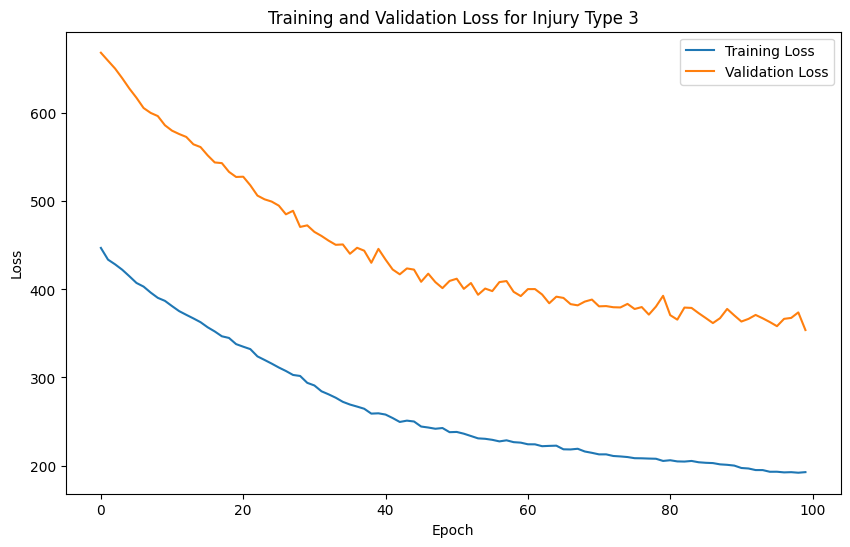

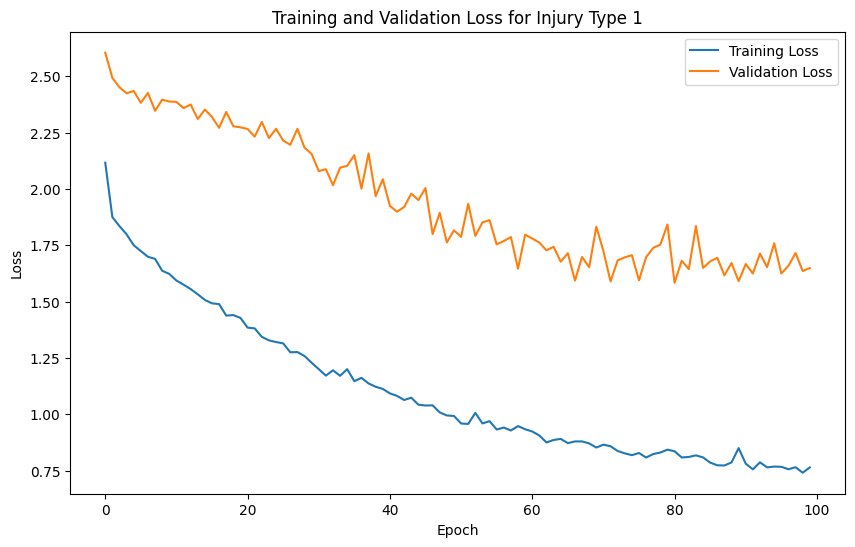

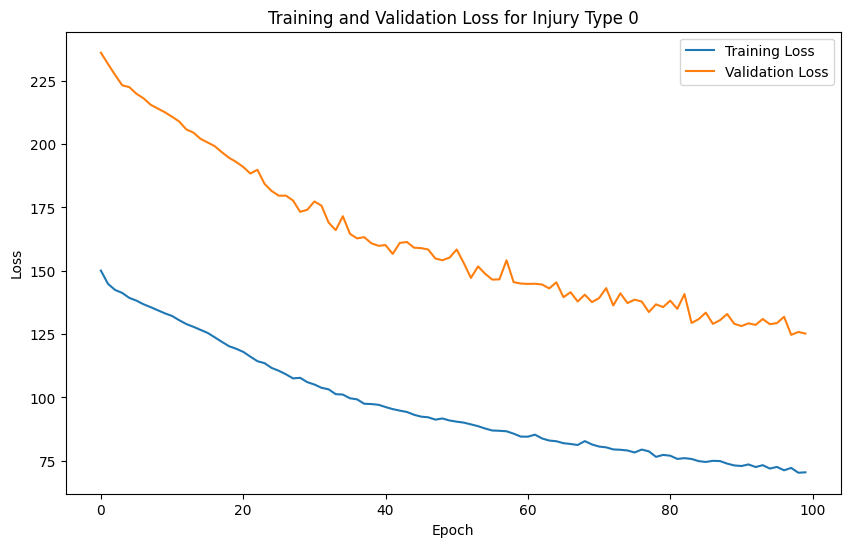

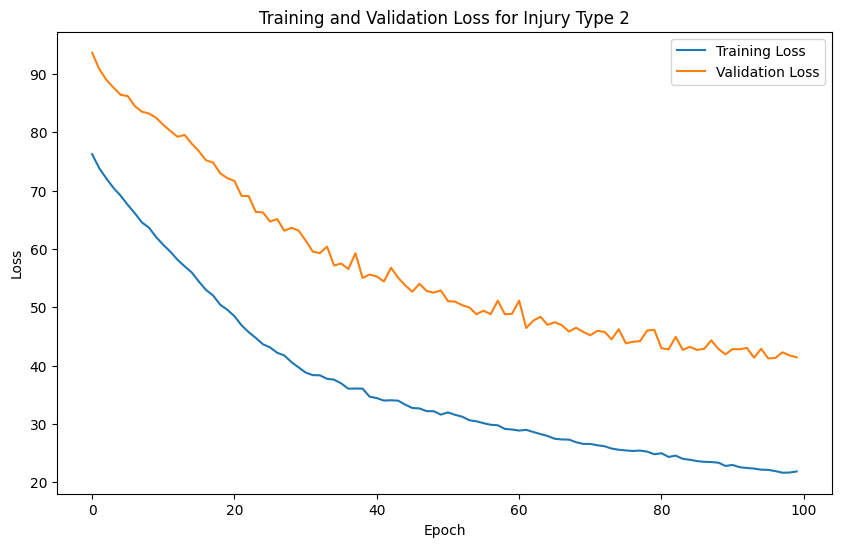

In [106]:
for injury_type, history in histories_dict.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for Injury Type {injury_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [55]:
# Example new_data (ensure it's preprocessed as per your model's training data)
# 1	0	3	0	10	1
new_data = [[1, 0, 3, 0, 7]]  # An example input array corresponding to ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle']

# Assuming the column names and order are ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle']
columns = ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle']
new_data_df = pd.DataFrame(new_data, columns=columns)

new_data_df = new_data_df.astype(float)
# Reshape if necessary (e.g., model expects a certain number of features)
new_data_np = new_data_df.to_numpy()
if len(new_data_np.shape) == 1:  # If it's a single sample, lacking an explicit batch dimension
    new_data_np = new_data_np.reshape(1, -1)


predictions = model.predict(new_data)

# Predict
predictions = model.predict(new_data_df)

print(predictions)  # This will output the predicted total incidents for the new data


1/1 [==============================] - 0s 22ms/step
[[3.7015712]]


In [56]:
# Assuming 'df' is your dataset
average_incidents = df['Total Incidents'].mean()

# Assuming 'new_data_df' is a new DataFrame with the same structure as your training data
# And that you've already applied necessary preprocessing
predictions = model.predict(new_data_df)

# Example for one prediction
predicted_incidents = predictions[0]  # Assuming this is the predicted total incidents for the first activity
consequence_factor = 1  # Adjust based on your understanding of severity

# Calculate the risk score
risk_score = (predicted_incidents / average_incidents) * consequence_factor

print(f"Risk Score for the activity: {risk_score}")


1/1 [==============================] - 0s 21ms/step
Risk Score for the activity: [0.9331692]


In [111]:
historical_average = df['Total Incidents'].mean()
print(f"Historical Average of Total Incidents: {historical_average}")


Historical Average of Total Incidents: 3.966666666666667


In [112]:
# Ensure new_data_df is prepared correctly (e.g., after encoding categorical variables)
new_data_df = new_data_df.astype(float)  # Convert to float
new_data_np = new_data_df.to_numpy()  # Convert DataFrame to NumPy array

# Reshape if new_data_np represents a single sample
if len(new_data_np.shape) == 1:
    new_data_np = new_data_np.reshape(1, -1)

# Make the prediction
predicted_incidents = model.predict(new_data_np).flatten()[0]
print(f"Predicted Total Incidents: {predicted_incidents}")


ValueError: could not convert string to float: 'unknown'

In [109]:
risk_factor = predicted_incidents / historical_average
if risk_factor > 1:
    print(f"Riskier than average. Risk factor: {risk_factor:.2f}")
elif risk_factor < 1:
    print(f"Safer than average. Risk factor: {risk_factor:.2f}")
else:
    print("Equal to the average risk.")


TypeError: unsupported format string passed to numpy.ndarray.__format__